#### 該文件包含1,338個案例，即目前已經登記過的保險計劃受益者、病人特點和計劃計入的總醫療費用特徵:

* age:表示主要受益者年齡
* sex:性別
* bmi:身體質量指數,理想BMI在18.5~24.9之間
* children:表示保險計劃中所包括的孩子/受撫養者的數量
* smoker:表示被保險人是否經常吸煙
* region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
* charges:醫療費用

#### 目的:檢測與醫療費用相關之變量，找出在醫療費用上具高風險的人

In [1]:
#測試環境是否在Uv內
import sys
print(sys.executable)

c:\Users\student\AIPE_MachineLearning\.venv\Scripts\python.exe


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# from sklearn.datasets import load_boston
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# 1. 處理 smoker：將 yes/no 轉為 1/0
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,0,northwest,10600.54830
1334,18,female,31.920,0,0,northeast,2205.98080
1335,18,female,36.850,0,0,southeast,1629.83350
1336,21,female,25.800,0,0,southwest,2007.94500


In [7]:
# 2. 處理 region 和 sex：使用 One-hot Encoding

# columns參數指定要轉換的欄位，dtype=int是為了讓它變成 0和1 (不然預設可能是 True/False)
df = pd.get_dummies(df, columns=['region', 'sex'], dtype=int)

# 檢查結果
df.head()

,age,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male
0,19,27.900,0,1,16884.92400,0,0,0,1,1,0
1,18,33.770,1,0,1725.55230,0,0,1,0,0,1
2,28,33.000,3,0,4449.46200,0,0,1,0,0,1
3,33,22.705,0,0,21984.47061,0,1,0,0,0,1
4,32,28.880,0,0,3866.85520,0,1,0,0,0,1


In [8]:
y_col = df.pop('charges')
df.head()

,age,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male
0,19,27.900,0,1,0,0,0,1,1,0
1,18,33.770,1,0,0,0,1,0,0,1
2,28,33.000,3,0,0,0,1,0,0,1
3,33,22.705,0,0,0,1,0,0,0,1
4,32,28.880,0,0,0,1,0,0,0,1


In [9]:
df['charges'] = y_col # charge弄到最右邊
df.head()

,age,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male,charges
0,19,27.900,0,1,0,0,0,1,1,0,16884.92400
1,18,33.770,1,0,0,0,1,0,0,1,1725.55230
2,28,33.000,3,0,0,0,1,0,0,1,4449.46200
3,33,22.705,0,0,0,1,0,0,0,1,21984.47061
4,32,28.880,0,0,0,1,0,0,0,1,3866.85520


In [10]:
# 1. 準備 X：把 'charges' 欄位丟掉，剩下的就是 X
X = df.drop(columns=['charges'])
# 2. 準備 y：只取 'charges' 這一欄
y = df['charges']
# 3. 檢查一下 X 和 y 的形狀 (shape)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1338, 10)
y shape: (1338,)


In [11]:
from sklearn.preprocessing import StandardScaler

# 1. 建立標準化工具箱
scaler = StandardScaler()

# 2. 指定要處理的欄位清單 (就是你剛剛挑出來的那三項)
cols_to_scale = ['age', 'bmi', 'children']

# 3. 進行標準化計算，並直接覆蓋回原本的 X
# fit_transform 的意思是：先學(fit)這欄的平均與標準差，再轉(transform)成新數值
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# 4. 檢查結果：看看這三欄是不是變成都在 0 附近的小數了？
X.head()

,age,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male
0,-1.438764,-0.453320,-0.908614,1,0,0,0,1,1,0
1,-1.509965,0.509621,-0.078767,0,0,0,1,0,0,1
2,-0.797954,0.383307,1.580926,0,0,0,1,0,0,1
3,-0.441948,-1.305531,-0.908614,0,0,1,0,0,0,1
4,-0.513149,-0.292556,-0.908614,0,0,1,0,0,0,1


In [12]:
from sklearn.model_selection import train_test_split

# test_size=0.3 代表切 30% 出來當考試題70% 用來訓練
# random_state=42 是一個種子碼，確保我們每次切出來的結果都一樣
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# 接著，我們建立並訓練模型
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)  # 只用訓練集 (X_train, y_train) 來學習

print("模型訓練完成！")
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")
df.isnull().sum()
# df.columns

模型訓練完成！
Shape of X_train:(936, 10)
Shape of X_test:(402, 10)
Shape of y_train:(936,)
Shape of y_test(402,)


age                 0
bmi                 0
children            0
smoker              0
region_northeast    0
region_northwest    0
region_southeast    0
region_southwest    0
sex_female          0
sex_male            0
charges             0
dtype: int64

In [13]:
df.describe()

,age,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.204783,0.242152,0.242900,0.272048,0.242900,0.494768,0.505232,13270.422265
std,14.049960,6.098187,1.205493,0.403694,0.428546,0.428995,0.445181,0.428995,0.500160,0.500160,12110.011237
min,18.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,16639.912515
max,64.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,63770.428010


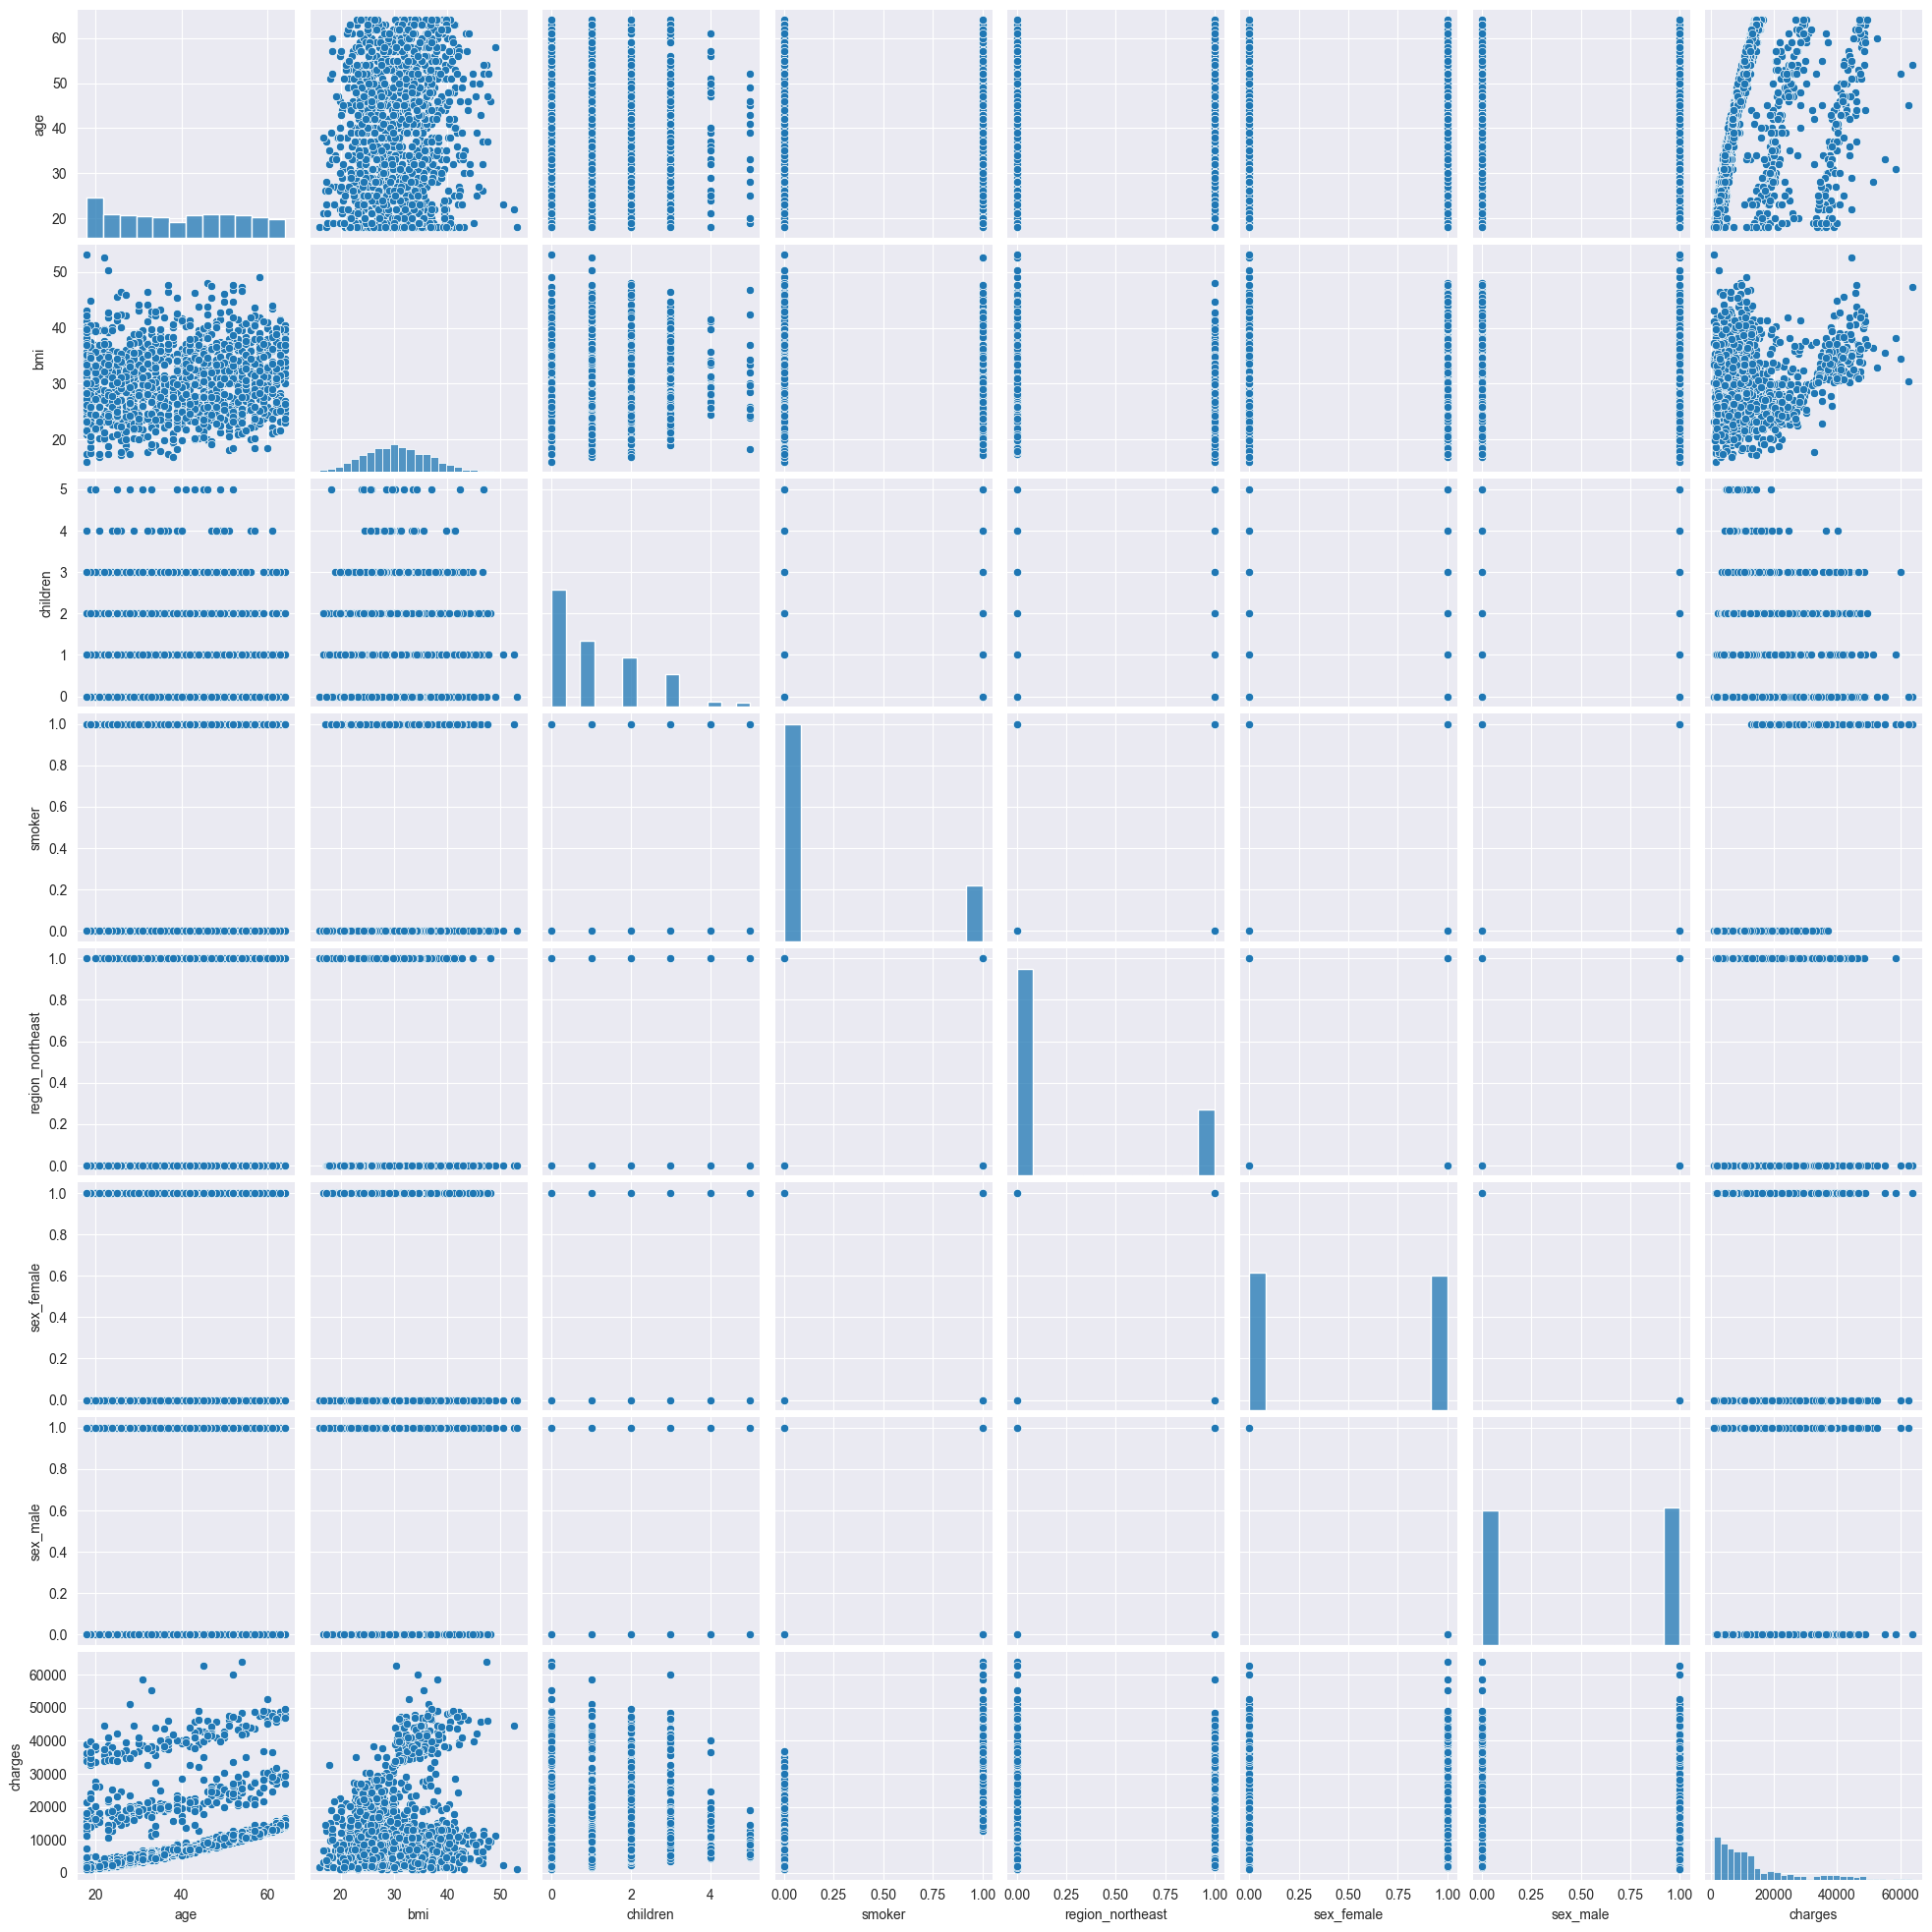

In [14]:
sns.pairplot(df[['age', 'bmi', 'children', 'smoker', 'region_northeast', 'sex_female', 'sex_male','charges']])

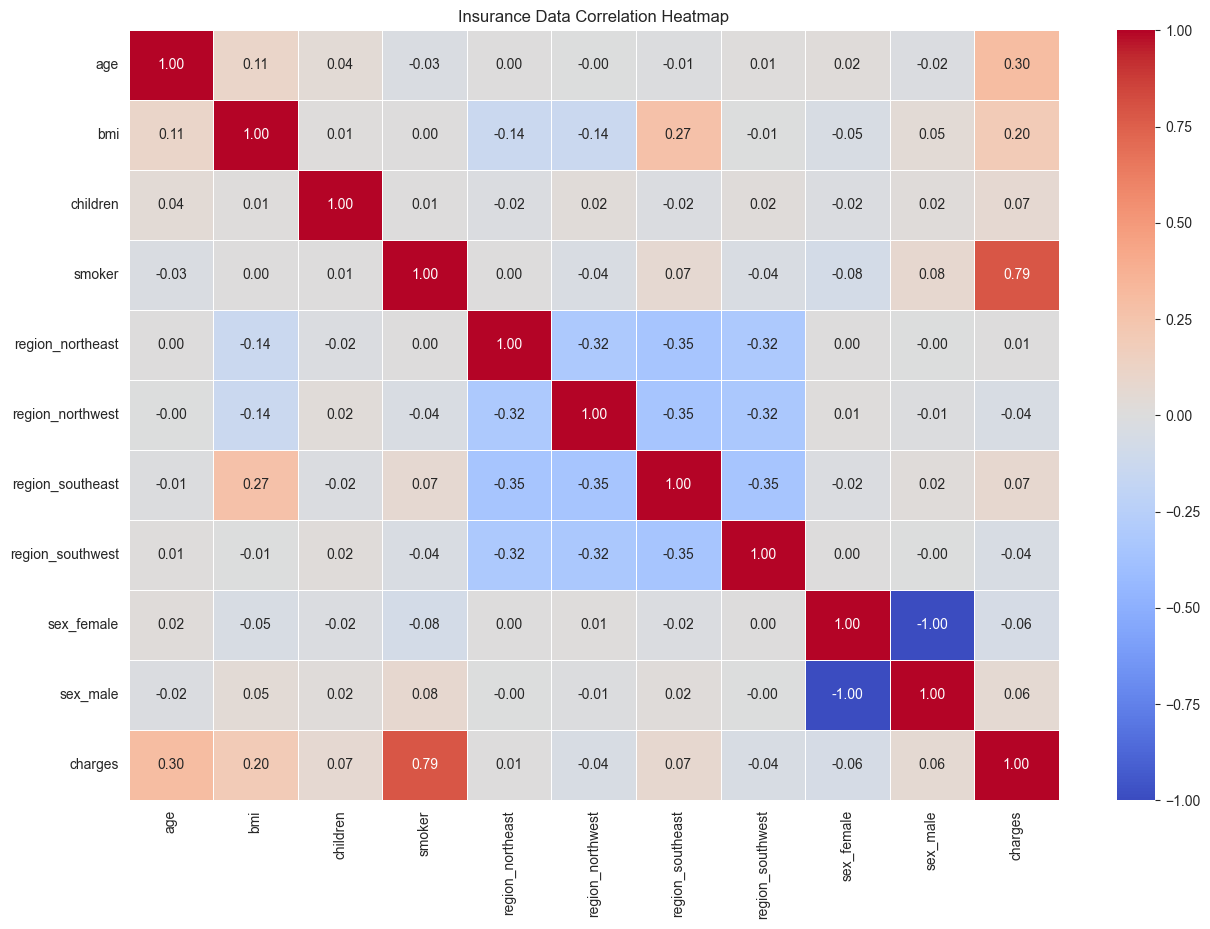

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 準備資料：為了畫圖，我們先把 X 和 y 黏在一起 (concat)
# axis=1 代表左右拼接
df_corr = pd.concat([X, y], axis=1)

# 2. 計算相關係數矩陣
correlation_matrix = df_corr.corr()

# 3. 畫出熱力圖
plt.figure(figsize=(15, 10))  # 設定圖的大小 (寬, 高)
sns.heatmap(correlation_matrix, 
            annot=True,       # 顯示數值
            cmap='coolwarm',  # 設定顏色 (紅藍色系通常比較容易看)
            fmt='.2f',        # 數值只顯示到小數點後兩位
            linewidths=0.5)   # 格子之間留點縫隙

plt.title('Insurance Data Correlation Heatmap')
plt.show()

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# 1. 預測訓練集 (看看平時練習狀況)
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# 2. 預測測試集 (看看期末考實力)
y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# 3. 印出成績單
print(f'R2 Score (Train): {r2_train:.4f}')
print(f'R2 Score (Test) : {r2_test:.4f}')
print('-' * 20)
print(f'RMSE (Train): {rmse_train:.2f}')
print(f'RMSE (Test) : {rmse_test:.2f}')

R2 Score (Train): 0.7635
R2 Score (Test) : 0.7161
--------------------
RMSE (Train): 5951.58
RMSE (Test) : 6278.92


In [17]:
from sklearn.preprocessing import PolynomialFeatures

# 1. 建立一個能產生「2次方」特徵的工具
# degree=2 代表我們要 x 的平方
poly = PolynomialFeatures(degree=2)

# 2. 把原本的 X 轉換成包含平方項的新 X (我們叫它 X_poly)
X_poly = poly.fit_transform(X)

print("原本 X 的形狀:", X.shape)
print("變身後 X_poly 的形狀:", X_poly.shape)

原本 X 的形狀: (1338, 10)
變身後 X_poly 的形狀: (1338, 66)


In [18]:
# 1. 切分資料 (注意：這次要用變身後的 X_poly 來切！)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=40)

# 2. 建立並訓練新模型
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# 3. 算出分數
y_pred_poly_train = model_poly.predict(X_train_poly) # 寫平時測驗卷
y_pred_poly_test = model_poly.predict(X_test_poly)   # 寫期末考卷

#計算 R2 分數 
r2_score_poly_train = r2_score(y_train, y_pred_poly_train)
r2_score_poly_test = r2_score(y_test, y_pred_poly_test)

#計算 RMSE 
rmse_poly_train = np.sqrt(mean_squared_error(y_train, y_pred_poly_train))
rmse_poly_test = np.sqrt(mean_squared_error(y_test, y_pred_poly_test))

print('=== Polynomial Regression Results ===')
print('R2_score (train): ', r2_score_poly_train)
print('R2_score (test):  ', r2_score_poly_test)
print("RMSE (train):     ", rmse_poly_train)
print("RMSE (test):      ", rmse_poly_test)

=== Polynomial Regression Results ===
R2_score (train):  0.8548519963273831
R2_score (test):   0.8226494375701863
RMSE (train):      4662.728185250375
RMSE (test):       4962.692499435066


In [19]:
lasso = Lasso(alpha = 0.05) # , positive=True
lasso.fit(X_train,y_train)

y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = lasso.score(X_train, y_train)

y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = lasso.score(X_test, y_test)

rmse_lasso_train = (np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)))

print("R2_score (train): ",r2_score_lasso_train)
print("R2_score (test):", r2_score_lasso_test)
print("train_RMSE: ", rmse_lasso_train)
print("test_RMSE: ", rmse_lasso_test)

R2_score (train):  0.7635193384403872
R2_score (test): 0.7161002936207447
train_RMSE:  5951.581446304052
test_RMSE:  6278.899802462072


In [20]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. 建立 Ridge 模型
# alpha (或 lambda) 是處罰力度。
# Lasso 您用了 0.05，Ridge 的 alpha 通常可以設大一點（如 1, 10, 100）來觀察效果。
# 我們先設 alpha=10 試試看 (您可以隨意調整測試)
ridge = Ridge(alpha=10)

# 2. 訓練模型 (Fit)
ridge.fit(X_train, y_train)

# 3. 預測 (Predict)
y_pred_ridge_train = ridge.predict(X_train)
y_pred_ridge_test = ridge.predict(X_test)

# 4. 評估指標 (Score & RMSE)
r2_score_ridge_train = ridge.score(X_train, y_train)
r2_score_ridge_test = ridge.score(X_test, y_test)

rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_pred_ridge_train))
rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))

# 5. 依照上課模式列印結果
print("R2_score (train): ", r2_score_ridge_train)
print("R2_score (test):  ", r2_score_ridge_test)
print("train_RMSE:       ", rmse_ridge_train)
print("test_RMSE:        ", rmse_ridge_test)

R2_score (train):  0.7611573396884481
R2_score (test):   0.7142791872136706
train_RMSE:        5981.230170497634
test_RMSE:         6299.005963087819


In [21]:
# 列印係數，查看模型認為哪些特徵重要
# 這裡將特徵名稱與係數對應印出
print("\nRidge 係數 (Coef):")
for feature, coef in zip(X.columns, ridge.coef_):
    print(f"{feature}: {coef:.4f}")


Ridge 係數 (Coef):
age: 3650.3434
bmi: 1956.4411
children: 686.9459
smoker: 22424.9669
region_northeast: 530.9486
region_northwest: -275.1932
region_southeast: 82.7387
region_southwest: -338.4940
sex_female: -9.5324
sex_male: 9.5324
